Initial center guess (min-wind): 26.269943237304688 -81.85115051269531
Vorticity center: 25.855913162231445 -83.72667694091797 proj coords (m): -187997.03751114965 -44514.622096991225


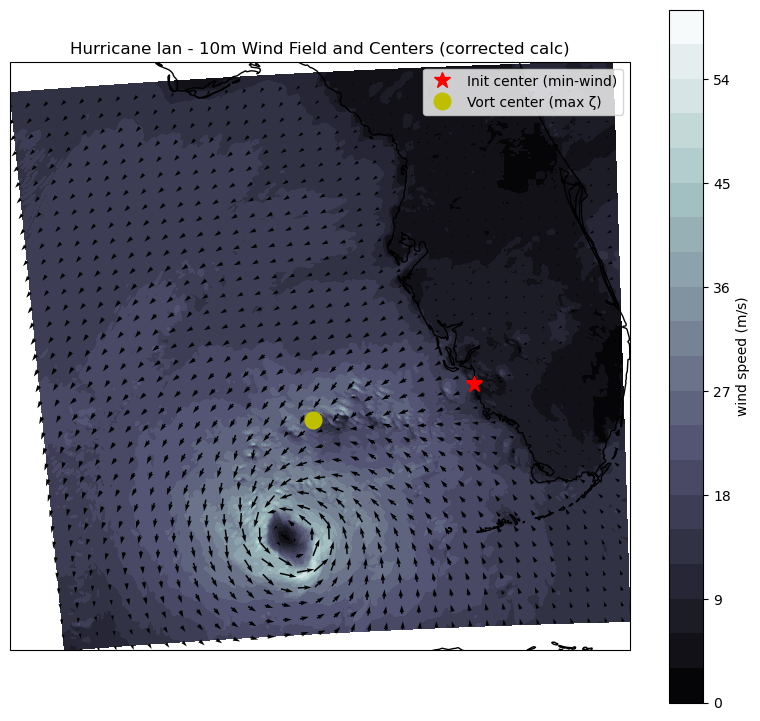

In [2]:
import numpy as np
import netCDF4 as nc
from pathlib import Path
from pyproj import Proj, Transformer, Geod
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ---- load WRF file (same as yours) ----
data_path = Path('data/wrfout_d03_2022-09-26_Ian2022_UNCPL.nc')
ds = nc.Dataset(data_path)
lat = ds.variables['XLAT'][0, :, :]    # 2D
lon = ds.variables['XLONG'][0, :, :]   # 2D
t = 51
u10 = ds.variables['U10'][t, :, :].astype(float)
v10 = ds.variables['V10'][t, :, :].astype(float)

# ---- initial guess for center (min wind) ----
wind_speed = np.sqrt(u10**2 + v10**2)
imin_ws = np.unravel_index(np.argmin(wind_speed), wind_speed.shape)
init_center_lat = float(lat[imin_ws])
init_center_lon = float(lon[imin_ws])
print("Initial center guess (min-wind):", init_center_lat, init_center_lon)

# ---- Make an AEQD projection centered at that guess ----
aeqd = Proj(proj='aeqd', lat_0=init_center_lat, lon_0=init_center_lon, datum='WGS84')
transformer_to_aeqd = Transformer.from_proj('epsg:4326', aeqd, always_xy=True)
# transform lon,lat arrays -> x,y in meters
x, y = transformer_to_aeqd.transform(lon, lat)   # x,y shaped like lon/lat
# optionally subtract center (should be near zero)
x = np.array(x); y = np.array(y)

# ---- Compute spatial derivatives in projected (meter) coords ----
# compute local dx (distance between adjacent x points) and dy between y points.
# We do elementwise spacing arrays using np.gradient on x and y
dx = np.gradient(x, axis=1)   # spacing in x-direction (meters)
dy = np.gradient(y, axis=0)   # spacing in y-direction (meters)

# compute dv/dx and du/dy (element-wise)
dvdx = np.gradient(v10, axis=1) / (dx + 1e-9)
dudy = np.gradient(u10, axis=0) / (dy + 1e-9)

# relative vorticity (no Coriolis)
vort = dvdx - dudy

# find meshpoint of max vorticity (vortex core candidate)
imax = np.unravel_index(np.argmax(vort), vort.shape)
center_lat_vort = float(lat[imax]); center_lon_vort = float(lon[imax])
center_x_vort = float(x[imax]); center_y_vort = float(y[imax])
print("Vorticity center:", center_lat_vort, center_lon_vort, "proj coords (m):", center_x_vort, center_y_vort)

# ---- Compute azimuth (bearing) from the vorticity center to ALL grid points ----
# Vectorized geodetic bearing: geod.inv(lon0, lat0, lon2_arr, lat2_arr)
geod = Geod(ellps='WGS84')
# Flatten arrays for speed; Geod.inv accepts arrays
lon_flat = lon.ravel()
lat_flat = lat.ravel()
az12, az21, dist = geod.inv(np.full_like(lon_flat, center_lon_vort),
                           np.full_like(lat_flat, center_lat_vort),
                           lon_flat, lat_flat)
# az12 is forward azimuth from center to gridpoint, measured clockwise from north (degrees)
azimuth = az12.reshape(lon.shape)  # degrees

# Convert azimuth to unit vector components (east, north)
# If az is clockwise from north:
# north component = cos(az_rad), east component = sin(az_rad)
az_rad = np.deg2rad(azimuth)
radial_east = np.sin(az_rad)
radial_north = np.cos(az_rad)

# radial and tangential winds (east/north components are u10 (eastward), v10 (northward))
radial_wind = u10 * radial_east + v10 * radial_north
tangential_wind = -u10 * radial_north + v10 * radial_east

# ---- Quick sanity-check plot (like your original) ----
fig, ax = plt.subplots(figsize=(10,9), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
cf = ax.contourf(lon, lat, wind_speed, levels=np.linspace(0, 60, 21), cmap='bone', transform=ccrs.PlateCarree())
ax.quiver(lon[::20,::20], lat[::20,::20], u10[::20,::20], v10[::20,::20], scale=1500, transform=ccrs.PlateCarree())

# Plot both centers: min-wind and vorticity
ax.plot(init_center_lon, init_center_lat, 'r*', markersize=12, label='Init center (min-wind)')
ax.plot(center_lon_vort, center_lat_vort, 'yo', markersize=12, label='Vort center (max ζ)')
ax.legend(loc='upper right')
plt.title('Hurricane Ian - 10m Wind Field and Centers (corrected calc)')
plt.colorbar(cf, ax=ax, orientation='vertical', label='wind speed (m/s)')
plt.show()

# ---- Optional: refine projection around vorticity center and recompute x,y etc ----
# If you want you can redo the AEQD projection using the vorticity center as lat_0/lon_0
# and then recompute dx/dy and derivatives for higher accuracy.


U10 dims: ('Time', 'south_north', 'west_east')
V10 dims: ('Time', 'south_north', 'west_east')
Initial center (min surface pressure): 24.40°, -83.88°
Refined center (max ζ within 150 km): 25.56°, -84.42°


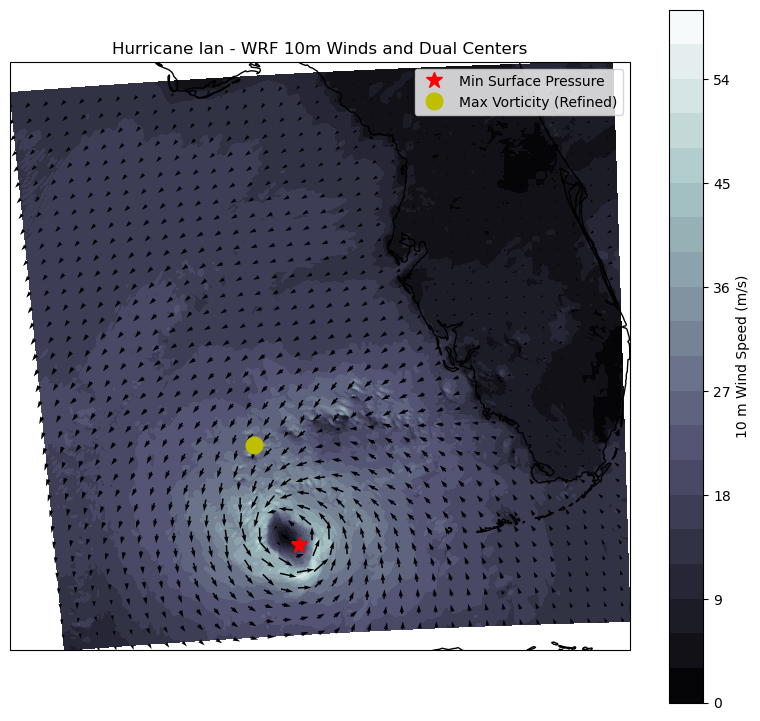


Final center estimates:
  Pressure minimum center : 24.40°, -83.88°
  Refined (dynamic) center : 25.56°, -84.42°
  Offset distance         : ~0.0 km


In [4]:
import numpy as np
import netCDF4 as nc
from pathlib import Path
from pyproj import Proj, Transformer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# 1. Load WRF data
# -----------------------------
data_path = Path('data/wrfout_d03_2022-09-26_Ian2022_UNCPL.nc')
ds = nc.Dataset(data_path)
lat = ds.variables['XLAT'][0, :, :]
lon = ds.variables['XLONG'][0, :, :]
t = 51  # choose your desired time index

# Check if U10/V10 are staggered
print("U10 dims:", ds.variables['U10'].dimensions)
print("V10 dims:", ds.variables['V10'].dimensions)

def unstagger(var, axis):
    """Unstagger a WRF variable along the specified axis."""
    return 0.5 * (var.take(indices=range(var.shape[axis]-1), axis=axis) +
                  var.take(indices=range(1, var.shape[axis]), axis=axis))

u10 = ds.variables['U10'][t, :, :]
v10 = ds.variables['V10'][t, :, :]

# Unstagger if needed
if 'west_east_stag' in ds.variables['U10'].dimensions:
    u10 = unstagger(u10, axis=1)
if 'south_north_stag' in ds.variables['V10'].dimensions:
    v10 = unstagger(v10, axis=0)

u10 = np.array(u10)
v10 = np.array(v10)

# -----------------------------
# 2. Step 1: Static center = min surface pressure
# -----------------------------
psfc = ds.variables['PSFC'][t, :, :]
imin_psfc = np.unravel_index(np.argmin(psfc), psfc.shape)
center_lat = float(lat[imin_psfc])
center_lon = float(lon[imin_psfc])
print(f"Initial center (min surface pressure): {center_lat:.2f}°, {center_lon:.2f}°")

# -----------------------------
# 3. AEQD projection centered at that point
# -----------------------------
aeqd = Proj(proj='aeqd', lat_0=center_lat, lon_0=center_lon, datum='WGS84')
transformer = Transformer.from_proj('epsg:4326', aeqd, always_xy=True)
x, y = transformer.transform(lon, lat)  # meters
x = np.array(x); y = np.array(y)

# -----------------------------
# 4. Compute relative vorticity (dynamic metric)
# -----------------------------
# dx, dy (in meters)
dx = np.gradient(x, axis=1)
dy = np.gradient(y, axis=0)
dvdx = np.gradient(v10, axis=1) / (dx + 1e-9)
dudy = np.gradient(u10, axis=0) / (dy + 1e-9)
vort = dvdx - dudy  # relative vorticity (no f-term)

# -----------------------------
# 5. Step 2: Refine to local vorticity max near the pressure min
# -----------------------------
# Define a search radius (km)
search_radius_km = 150  # adjust as needed
r = np.sqrt(x**2 + y**2) / 1000.0
mask = r <= search_radius_km
vort_masked = np.where(mask, vort, np.nan)

imax = np.unravel_index(np.nanargmax(vort_masked), vort.shape)
refined_lat = float(lat[imax])
refined_lon = float(lon[imax])
print(f"Refined center (max ζ within {search_radius_km} km): {refined_lat:.2f}°, {refined_lon:.2f}°")

# -----------------------------
# 6. Compute radial and tangential wind relative to refined center
# -----------------------------
# Reproject with refined center for accurate r, theta
aeqd_refined = Proj(proj='aeqd', lat_0=refined_lat, lon_0=refined_lon, datum='WGS84')
transformer_refined = Transformer.from_proj('epsg:4326', aeqd_refined, always_xy=True)
x_ref, y_ref = transformer_refined.transform(lon, lat)
r = np.sqrt(x_ref**2 + y_ref**2)
theta = np.arctan2(y_ref, x_ref)

# Radial/tangential components
radial_wind = u10 * np.cos(theta) + v10 * np.sin(theta)
tangential_wind = -u10 * np.sin(theta) + v10 * np.cos(theta)

# -----------------------------
# 7. Visualization
# -----------------------------
wind_speed = np.sqrt(u10**2 + v10**2)
fig, ax = plt.subplots(figsize=(10,9), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
cf = ax.contourf(lon, lat, wind_speed, levels=np.linspace(0, 60, 21), cmap='bone', transform=ccrs.PlateCarree())
ax.quiver(lon[::20,::20], lat[::20,::20], u10[::20,::20], v10[::20,::20], scale=1500, transform=ccrs.PlateCarree())

ax.plot(center_lon, center_lat, 'r*', markersize=12, label='Min Surface Pressure')
ax.plot(refined_lon, refined_lat, 'yo', markersize=12, label='Max Vorticity (Refined)')
ax.legend(loc='upper right')
plt.title('Hurricane Ian - WRF 10m Winds and Dual Centers')
plt.colorbar(cf, ax=ax, orientation='vertical', label='10 m Wind Speed (m/s)')
plt.show()

# -----------------------------
# 8. Optional: Print results cleanly
# -----------------------------
print("\nFinal center estimates:")
print(f"  Pressure minimum center : {center_lat:.2f}°, {center_lon:.2f}°")
print(f"  Refined (dynamic) center : {refined_lat:.2f}°, {refined_lon:.2f}°")
print(f"  Offset distance         : ~{np.sqrt((x_ref[imax])**2 + (y_ref[imax])**2)/1000:.1f} km")


Initial min-pressure point: 24.39824676513672 -83.88214874267578
Iter 1: current=(24.3982,-83.8821) -> new=(24.7111,-84.0103) move=37.01 km; vort=(25.5619,-84.4152); pcent=(24.3465,-83.8368)
Iter 2: current=(24.7111,-84.0103) -> new=(25.1096,-83.9283) move=44.92 km; vort=(25.8559,-83.7267); pcent=(24.7898,-84.0147)
Iter 3: current=(25.1096,-83.9283) -> new=(25.4420,-83.8551) move=37.55 km; vort=(25.8559,-83.7267); pcent=(25.2646,-83.9101)
Iter 4: current=(25.4420,-83.8551) -> new=(25.6454,-83.8046) move=23.10 km; vort=(25.8559,-83.7267); pcent=(25.5552,-83.8380)
Iter 5: current=(25.6454,-83.8046) -> new=(25.7750,-83.7722) move=14.72 km; vort=(25.8559,-83.7267); pcent=(25.7403,-83.7917)
Iter 6: current=(25.7750,-83.7722) -> new=(25.8666,-83.7503) move=10.39 km; vort=(25.8559,-83.7267); pcent=(25.8712,-83.7604)
Iter 7: current=(25.8666,-83.7503) -> new=(25.9411,-83.7345) move=8.40 km; vort=(25.8559,-83.7267); pcent=(25.9777,-83.7379)
Iter 8: current=(25.9411,-83.7345) -> new=(26.0026,-83

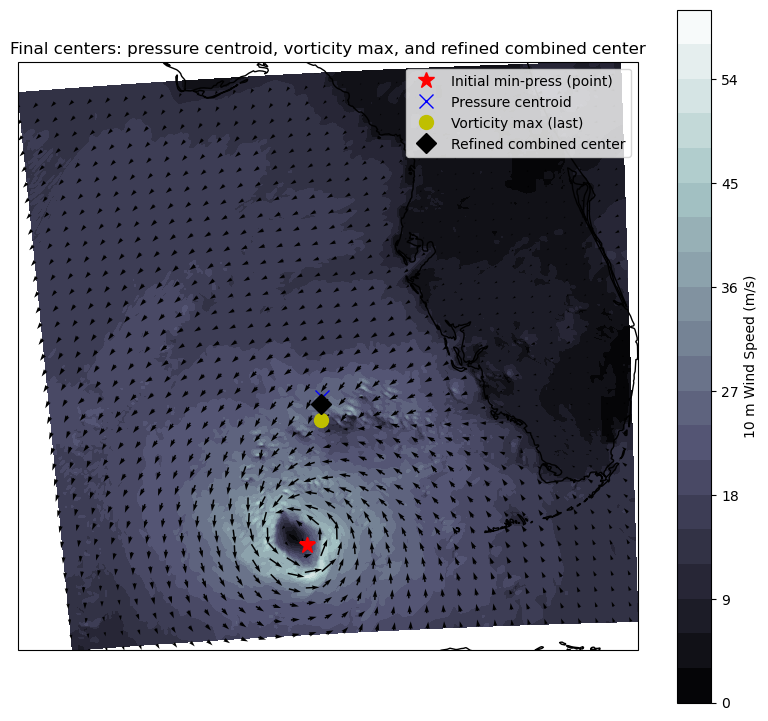

In [5]:
import numpy as np
import netCDF4 as nc
from pathlib import Path
from pyproj import Proj, Transformer, Geod
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Optional smoothing - use scipy if available, else fallback to simple box filter
try:
    from scipy.ndimage import gaussian_filter
    _has_gauss = True
except Exception:
    _has_gauss = False
    def gaussian_filter(arr, sigma):
        # rough fallback: small uniform filter using convolution
        k = int(max(1, round(sigma*2)))  # kernel size proxy
        if k % 2 == 0:
            k += 1
        kernel = np.ones((k, k)) / (k*k)
        from scipy.signal import convolve2d
        return convolve2d(arr, kernel, mode='same', boundary='symm')

# -----------------------------
# Parameters (tune these)
# -----------------------------
data_path = Path('data/wrfout_d03_2022-09-26_Ian2022_UNCPL.nc')
time_index = 51
search_radius_km = 150.0       # where we search for vorticity/pressure centroid
smooth_sigma = 1.5             # sigma for gaussian smoothing (grid points)
pressure_centroid_radius_km = 100.0
weight_pressure = 0.7          # combined center = w*pressure_centroid + (1-w)*vort_max
convergence_tol_km = 5.0       # stop when movement < this
max_iterations = 10

# -----------------------------
# Load data
# -----------------------------
ds = nc.Dataset(data_path)
lat = ds.variables['XLAT'][0, :, :].astype(float)
lon = ds.variables['XLONG'][0, :, :].astype(float)

# Prefer PSFC if present; fallback to surface_pressure variable names.
if 'PSFC' in ds.variables:
    psfc = ds.variables['PSFC'][time_index, :, :].astype(float)
else:
    # try other names, or compute from pressure/perturbation if user has those
    raise KeyError("PSFC not found in file; please provide a surface pressure variable")

# Prefer a low-level wind (e.g., lowest model level U/V or U10/V10). 
# Here we try U10/V10, but if you have 'U'/'V' 3D you might want level 0 or level 1.
if 'U10' in ds.variables and 'V10' in ds.variables:
    u = ds.variables['U10'][time_index, :, :].astype(float)
    v = ds.variables['V10'][time_index, :, :].astype(float)
else:
    raise KeyError("U10/V10 not in file. If you have 3D U/V, extract a low model level.")

# Helper: unstagger if needed
def unstagger(var, axis):
    return 0.5 * (var.take(indices=range(var.shape[axis]-1), axis=axis) +
                  var.take(indices=range(1, var.shape[axis]), axis=axis))

# If dataset shows stag dims, unstagger fields (safe-guard)
if 'west_east_stag' in ds.variables.get('U10', ds.variables.keys()).dimensions:
    u = unstagger(u, axis=1)
if 'south_north_stag' in ds.variables.get('V10', ds.variables.keys()).dimensions:
    v = unstagger(v, axis=0)

# Make copies as float arrays
lat = np.array(lat)
lon = np.array(lon)
u = np.array(u)
v = np.array(v)
psfc = np.array(psfc)

# -----------------------------
# Initial center: pressure minimum (point)
# -----------------------------
imin = np.unravel_index(np.argmin(psfc), psfc.shape)
center_lat = float(lat[imin]); center_lon = float(lon[imin])
print("Initial min-pressure point:", center_lat, center_lon)

# -----------------------------
# Iterative refinement routine
# -----------------------------
geod = Geod(ellps='WGS84')

def project_aeqd(lat0, lon0, lon_arr, lat_arr):
    aeqd = Proj(proj='aeqd', lat_0=lat0, lon_0=lon0, datum='WGS84')
    t = Transformer.from_proj('epsg:4326', aeqd, always_xy=True)
    x2d, y2d = t.transform(lon_arr, lat_arr)
    return np.array(x2d), np.array(y2d), aeqd

def compute_vorticity_in_proj(u_field, v_field, x_proj, y_proj):
    # compute dx, dy (meters)
    dx = np.gradient(x_proj, axis=1)
    dy = np.gradient(y_proj, axis=0)
    # derivatives
    dvdx = np.gradient(v_field, axis=1) / (dx + 1e-9)
    dudy = np.gradient(u_field, axis=0) / (dy + 1e-9)
    return dvdx - dudy

def pressure_centroid(psfc_local, lon_arr, lat_arr, center_lat, center_lon, radius_km):
    # compute AEQD coords about center_lat/lon to get distance mask
    x_c, y_c, _ = project_aeqd(center_lat, center_lon, lon_arr, lat_arr)
    r_km = np.sqrt(x_c**2 + y_c**2)/1000.0
    mask = r_km <= radius_km
    if not np.any(mask):
        return center_lat, center_lon
    # weight = pressure deficit (min - p), clip to positive
    pmin = np.nanmin(psfc_local[mask])
    weight = np.where(mask, (pmin - psfc_local), 0.0)  # positive inside low region
    # if weights all zero (flat), fallback to simple min
    if np.allclose(weight, 0):
        idx = np.unravel_index(np.nanargmin(psfc_local), psfc_local.shape)
        return float(lat_arr[idx]), float(lon_arr[idx])
    # compute weighted centroid in lon/lat via converting to x,y meters THEN back to lon/lat
    # project to center projection to get planar coords to compute centroid robustly
    x_proj, y_proj, aeqd = project_aeqd(center_lat, center_lon, lon_arr, lat_arr)
    x_cent = np.nansum(weight * x_proj) / (np.nansum(weight) + 1e-12)
    y_cent = np.nansum(weight * y_proj) / (np.nansum(weight) + 1e-12)
    # inverse transform to lon/lat using Proj
    lon_cent, lat_cent = aeqd(x_cent, y_cent, inverse=True)
    return float(lat_cent), float(lon_cent)

def km_between(lat1, lon1, lat2, lon2):
    az12, az21, dist_m = geod.inv(lon1, lat1, lon2, lat2)
    return dist_m/1000.0

# smoothing
if _has_gauss:
    u_smooth = gaussian_filter(u, sigma=smooth_sigma)
    v_smooth = gaussian_filter(v, sigma=smooth_sigma)
    p_smooth = gaussian_filter(psfc, sigma=smooth_sigma)
else:
    u_smooth = u.copy()
    v_smooth = v.copy()
    p_smooth = psfc.copy()

# begin iteration
current_lat = center_lat
current_lon = center_lon

for it in range(max_iterations):
    # project fields to AEQD around current center
    x_proj, y_proj, aeqd_proj = project_aeqd(current_lat, current_lon, lon, lat)
    # compute vorticity on smoothed winds
    vort = compute_vorticity_in_proj(u_smooth, v_smooth, x_proj, y_proj)
    # mask to search radius
    r_km = np.sqrt(x_proj**2 + y_proj**2)/1000.0
    mask = r_km <= search_radius_km
    if not np.any(mask):
        print("No points in search radius; stopping.")
        break
    # find vorticity max within mask
    masked_vort = np.where(mask, vort, np.nan)
    vmax_idx = np.unravel_index(np.nanargmax(masked_vort), masked_vort.shape)
    vort_lat = float(lat[vmax_idx]); vort_lon = float(lon[vmax_idx])
    # pressure centroid within smaller radius
    pcent_lat, pcent_lon = pressure_centroid(p_smooth, lon, lat, current_lat, current_lon, pressure_centroid_radius_km)
    # combine them (weighted)
    new_lat = weight_pressure * pcent_lat + (1.0 - weight_pressure) * vort_lat
    new_lon = weight_pressure * pcent_lon + (1.0 - weight_pressure) * vort_lon
    move_km = km_between(current_lat, current_lon, new_lat, new_lon)
    print(f"Iter {it+1}: current=({current_lat:.4f},{current_lon:.4f}) -> new=({new_lat:.4f},{new_lon:.4f}) move={move_km:.2f} km; vort=({vort_lat:.4f},{vort_lon:.4f}); pcent=({pcent_lat:.4f},{pcent_lon:.4f})")
    current_lat, current_lon = new_lat, new_lon
    # optional: recompute smooth fields centered? We keep same u_smooth/v_smooth/p_smooth
    if move_km < convergence_tol_km:
        print("Converged.")
        break

refined_lat = current_lat
refined_lon = current_lon

# Final diagnostics: measure offsets of key points relative to refined center
# compute positions of initial min-pressure point and vort point in final projection
x_final, y_final, _ = project_aeqd(refined_lat, refined_lon, lon, lat)
imin_ps = np.unravel_index(np.argmin(psfc), psfc.shape)
ps_lat = float(lat[imin_ps]); ps_lon = float(lon[imin_ps])
vmax_idx = vmax_idx  # from last iteration
vort_lat = float(lat[vmax_idx]); vort_lon = float(lon[vmax_idx])

print("\nResults:")
print(f"  initial min-pressure point : {center_lat:.5f}, {center_lon:.5f}  (that's the first guess)")
print(f"  pressure-centroid (last)   : {pcent_lat:.5f}, {pcent_lon:.5f}")
print(f"  vorticity-max (last)      : {vort_lat:.5f}, {vort_lon:.5f}")
print(f"  refined center (combined) : {refined_lat:.5f}, {refined_lon:.5f}")
print(f"  offset from initial min-press -> refined : {km_between(center_lat, center_lon, refined_lat, refined_lon):.2f} km")
print(f"  offset vort->refined: {km_between(vort_lat, vort_lon, refined_lat, refined_lon):.2f} km")
print(f"  offset min-press->vort: {km_between(center_lat, center_lon, vort_lat, vort_lon):.2f} km")

# -----------------------------
# Plot final results (like you had)
# -----------------------------
wind_speed = np.sqrt(u**2 + v**2)
fig, ax = plt.subplots(figsize=(10,9), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
cf = ax.contourf(lon, lat, wind_speed, levels=np.linspace(0, 60, 21), cmap='bone', transform=ccrs.PlateCarree())
ax.quiver(lon[::20,::20], lat[::20,::20], u[::20,::20], v[::20,::20], scale=1500, transform=ccrs.PlateCarree())
ax.plot(center_lon, center_lat, 'r*', markersize=12, label='Initial min-press (point)')
ax.plot(pcent_lon, pcent_lat, 'bx', markersize=10, label='Pressure centroid')
ax.plot(vort_lon, vort_lat, 'yo', markersize=10, label='Vorticity max (last)')
ax.plot(refined_lon, refined_lat, 'kD', markersize=10, label='Refined combined center')
ax.legend(loc='upper right')
plt.title('Final centers: pressure centroid, vorticity max, and refined combined center')
plt.colorbar(cf, ax=ax, orientation='vertical', label='10 m Wind Speed (m/s)')
plt.show()


U10 dims: ('Time', 'south_north', 'west_east')
V10 dims: ('Time', 'south_north', 'west_east')
Initial center (min surface pressure): 27.03°, -83.92°
Refined center (eyewall-based max tangential wind): 26.95°, -83.81°


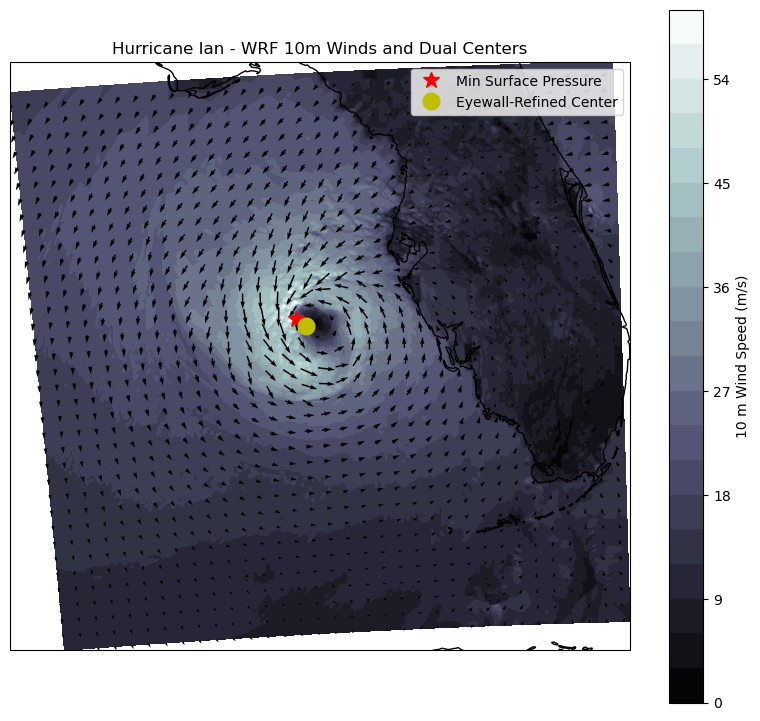


Final center estimates:
  Pressure minimum center : 27.03°, -83.92°
  Eyewall-refined center   : 26.95°, -83.81°
  Offset distance          : ~14.3 km


In [9]:
import numpy as np
import netCDF4 as nc
from pathlib import Path
from pyproj import Proj, Transformer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic  # Add this import

# -----------------------------
# 1. Load WRF data (unchanged)
# -----------------------------
data_path = Path('data/wrfout_d03_2022-09-26_Ian2022_UNCPL.nc')
ds = nc.Dataset(data_path)
lat = ds.variables['XLAT'][0, :, :]
lon = ds.variables['XLONG'][0, :, :]
t = 71  # choose your desired time index

# Unstagger U10/V10 if needed (unchanged)
print("U10 dims:", ds.variables['U10'].dimensions)
print("V10 dims:", ds.variables['V10'].dimensions)

def unstagger(var, axis):
    """Unstagger a WRF variable along the specified axis."""
    return 0.5 * (var.take(indices=range(var.shape[axis]-1), axis=axis) +
                  var.take(indices=range(1, var.shape[axis]), axis=axis))

u10 = ds.variables['U10'][t, :, :]
v10 = ds.variables['V10'][t, :, :]

if 'west_east_stag' in ds.variables['U10'].dimensions:
    u10 = unstagger(u10, axis=1)
if 'south_north_stag' in ds.variables['V10'].dimensions:
    v10 = unstagger(v10, axis=0)

u10 = np.array(u10)
v10 = np.array(v10)

# -----------------------------
# 2. Step 1: Initial center = min surface pressure (unchanged)
# -----------------------------
psfc = ds.variables['PSFC'][t, :, :]
imin_psfc = np.unravel_index(np.argmin(psfc), psfc.shape)
center_lat = float(lat[imin_psfc])
center_lon = float(lon[imin_psfc])
print(f"Initial center (min surface pressure): {center_lat:.2f}°, {center_lon:.2f}°")

# -----------------------------
# New: Step 2: Refine based on eyewall (max tangential wind in RMW annulus)
# -----------------------------
# Define search parameters
search_radius_km = 150  # Max radius for binning (focus on inner core)
annulus_width_km = 8  # Half-width of annulus around RMW
search_box = 10  # Grid points to search around initial center (± this value)

# Get indices around initial center
i_min, j_min = imin_psfc
i_range = range(max(0, i_min - search_box), min(lat.shape[0], i_min + search_box + 1))
j_range = range(max(0, j_min - search_box), min(lat.shape[1], j_min + search_box + 1))

max_annulus_mean = -np.inf
refined_lat = center_lat
refined_lon = center_lon

for i in i_range:
    for j in j_range:
        cand_lat = lat[i, j]
        cand_lon = lon[i, j]
        
        # Project to AEQD centered at candidate
        aeqd = Proj(proj='aeqd', lat_0=cand_lat, lon_0=cand_lon, datum='WGS84')
        transformer = Transformer.from_proj('epsg:4326', aeqd, always_xy=True)
        x, y = transformer.transform(lon, lat)
        
        # Compute radial distance and azimuthal angle
        r = np.sqrt(x**2 + y**2) / 1000.0  # km
        theta = np.arctan2(y, x)
        
        # Mask beyond search radius to focus on core
        mask = r <= search_radius_km
        r_masked = np.where(mask, r, np.nan)
        theta_masked = np.where(mask, theta, np.nan)
        u10_masked = np.where(mask, u10, np.nan)
        v10_masked = np.where(mask, v10, np.nan)
        
        # Tangential wind (positive for cyclonic in NH)
        tangential = -u10_masked * np.sin(theta_masked) + v10_masked * np.cos(theta_masked)
        
        # Bin azimuthal mean tangential wind by r
        bins = np.linspace(0, search_radius_km, 100)  # Adjust bin count as needed
        mean_tang, bin_edges, _ = binned_statistic(r_masked.flatten(), tangential.flatten(), statistic='mean', bins=bins)
        r_mid = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Find RMW (ignore NaNs)
        valid = ~np.isnan(mean_tang)
        if not np.any(valid):
            continue
        rmw = r_mid[valid][np.argmax(mean_tang[valid])]
        
        # Annulus around RMW
        annulus_mask = (r_masked >= rmw - annulus_width_km) & (r_masked < rmw + annulus_width_km)
        if np.sum(annulus_mask) == 0:
            continue
        annulus_mean = np.nanmean(tangential[annulus_mask])
        
        # Update if this is the max
        if annulus_mean > max_annulus_mean:
            max_annulus_mean = annulus_mean
            refined_lat = cand_lat
            refined_lon = cand_lon

print(f"Refined center (eyewall-based max tangential wind): {refined_lat:.2f}°, {refined_lon:.2f}°")

# -----------------------------
# 3. Compute radial and tangential wind relative to refined center (unchanged, but now uses eyewall-refined)
# -----------------------------
aeqd_refined = Proj(proj='aeqd', lat_0=refined_lat, lon_0=refined_lon, datum='WGS84')
transformer_refined = Transformer.from_proj('epsg:4326', aeqd_refined, always_xy=True)
x_ref, y_ref = transformer_refined.transform(lon, lat)
r = np.sqrt(x_ref**2 + y_ref**2)
theta = np.arctan2(y_ref, x_ref)

radial_wind = u10 * np.cos(theta) + v10 * np.sin(theta)
tangential_wind = -u10 * np.sin(theta) + v10 * np.cos(theta)

# -----------------------------
# 4. Visualization (unchanged, but now refined should be better centered)
# -----------------------------
wind_speed = np.sqrt(u10**2 + v10**2)
fig, ax = plt.subplots(figsize=(10,9), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
cf = ax.contourf(lon, lat, wind_speed, levels=np.linspace(0, 60, 21), cmap='bone', transform=ccrs.PlateCarree())
ax.quiver(lon[::20,::20], lat[::20,::20], u10[::20,::20], v10[::20,::20], scale=1500, transform=ccrs.PlateCarree())

ax.plot(center_lon, center_lat, 'r*', markersize=12, label='Min Surface Pressure')
ax.plot(refined_lon, refined_lat, 'yo', markersize=12, label='Eyewall-Refined Center')
ax.legend(loc='upper right')
plt.title('Hurricane Ian - WRF 10m Winds and Dual Centers')
plt.colorbar(cf, ax=ax, orientation='vertical', label='10 m Wind Speed (m/s)')
plt.show()

# -----------------------------
# 5. Optional: Print results cleanly (updated)
# -----------------------------
print("\nFinal center estimates:")
print(f"  Pressure minimum center : {center_lat:.2f}°, {center_lon:.2f}°")
print(f"  Eyewall-refined center   : {refined_lat:.2f}°, {refined_lon:.2f}°")
# Offset computation (reproject if needed for accuracy)
aeqd_refined = Proj(proj='aeqd', lat_0=center_lat, lon_0=center_lon, datum='WGS84')  # From initial to refined
x_off, y_off = Transformer.from_proj('epsg:4326', aeqd_refined, always_xy=True).transform(refined_lon, refined_lat)
offset_km = np.sqrt(x_off**2 + y_off**2) / 1000
print(f"  Offset distance          : ~{offset_km:.1f} km")

Initial center (min surface pressure): 27.03°, -83.92°
Refined center (eyewall-based max tangential wind): 26.95°, -83.81°


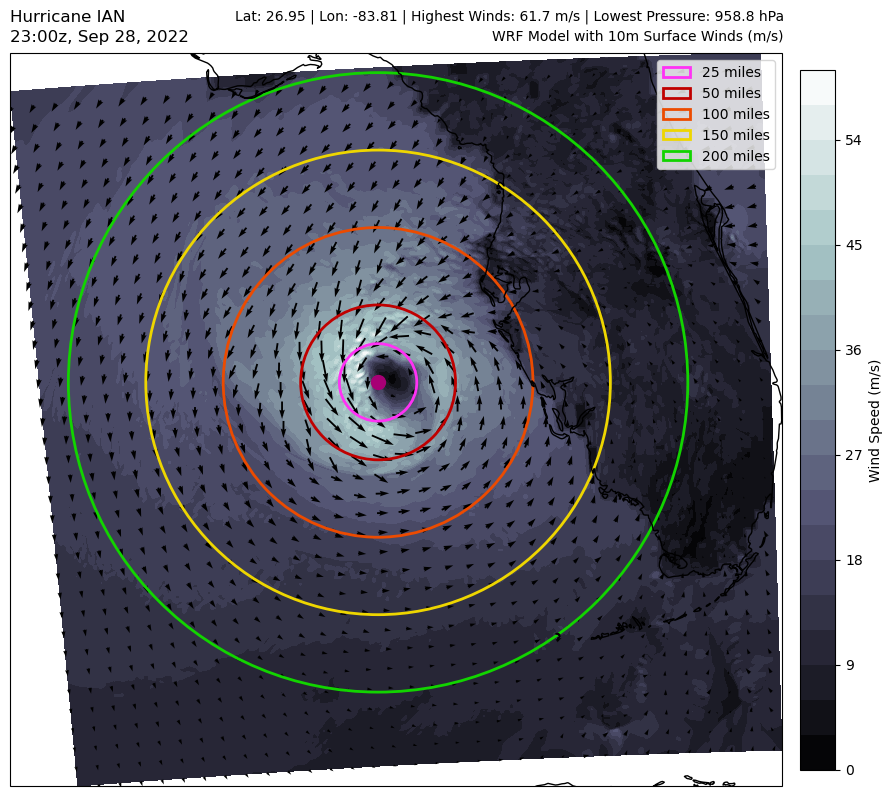


Final center estimates:
  Pressure minimum center : 27.03°, -83.92°
  Eyewall-refined center   : 26.95°, -83.81°
  Offset distance          : ~14.3 km


In [13]:
# ---------------------------------------------------------------------------------------
# 1. Import Python libraries
# ---------------------------------------------------------------------------------------
import numpy as np
import netCDF4 as nc
from pathlib import Path
from pyproj import Proj, Transformer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic
from datetime import datetime

# ---------------------------------------------------------------------------------------
# 2. Load WRF data
# ---------------------------------------------------------------------------------------
data_path = Path('data/wrfout_d03_2022-09-26_Ian2022_UNCPL.nc')
ds = nc.Dataset(data_path)
t = 71  # choose desired timestep

# Get lat/lon
lat = ds.variables['XLAT'][0, :, :]
lon = ds.variables['XLONG'][0, :, :]

# ---------------------------------------------------------------------------------------
# 3. Unstagger U10 and V10 components
# ---------------------------------------------------------------------------------------
# Check if U10/V10 are staggered
# print("U10 dims:", ds.variables['U10'].dimensions)
# print("V10 dims:", ds.variables['V10'].dimensions)

# Function: Unstagger WRF variables
def unstagger(var, axis):
    return 0.5 * (var.take(indices=range(var.shape[axis]-1), axis=axis) +
                  var.take(indices=range(1, var.shape[axis]), axis=axis))

u10 = ds.variables['U10'][t, :, :]
v10 = ds.variables['V10'][t, :, :]

if 'west_east_stag' in ds.variables['U10'].dimensions:
    u10 = unstagger(u10, axis=1)
if 'south_north_stag' in ds.variables['V10'].dimensions:
    v10 = unstagger(v10, axis=0)

u10 = np.array(u10)
v10 = np.array(v10)

# ---------------------------------------------------------------------------------------
# 3. Set initial best center to be minimum surface pressure (unchanged)
# ---------------------------------------------------------------------------------------
psfc = ds.variables['PSFC'][t, :, :]
imin_psfc = np.unravel_index(np.argmin(psfc), psfc.shape)
center_lat = float(lat[imin_psfc])
center_lon = float(lon[imin_psfc])
print(f"Initial center (min surface pressure): {center_lat:.2f}°, {center_lon:.2f}°")

# ---------------------------------------------------------------------------------------
# 4. Refine center based on eyewall (max tangential wind in RMW annulus)
# ---------------------------------------------------------------------------------------
# Define search parameters
search_radius_km = 150  # max radius for binning (focus on inner core)
annulus_width_km = 12  # half-width of annulus around RMW
search_box = 10  # grid points to search around initial center (+/- value)

# Get indices around initial center
i_min, j_min = imin_psfc
i_range = range(max(0, i_min - search_box), min(lat.shape[0], i_min + search_box + 1))
j_range = range(max(0, j_min - search_box), min(lat.shape[1], j_min + search_box + 1))

# Initialize variables to track max annulus mean tangential wind
max_annulus_mean = -np.inf
refined_lat = center_lat
refined_lon = center_lon

for i in i_range: # Loop over candidate center latitudes
    for j in j_range: # Loop over candidate center longitudes
        cand_lat = lat[i, j]
        cand_lon = lon[i, j]
        
        # Project to AEQD centered at candidate
        aeqd = Proj(proj='aeqd', lat_0=cand_lat, lon_0=cand_lon, datum='WGS84')
        transformer = Transformer.from_proj('epsg:4326', aeqd, always_xy=True)
        x, y = transformer.transform(lon, lat)
        
        # Compute radial distance and azimuthal angle
        r = np.sqrt(x**2 + y**2) / 1000.0  # km
        theta = np.arctan2(y, x)
        
        # Mask beyond search radius to focus on core
        mask = r <= search_radius_km
        r_masked = np.where(mask, r, np.nan)
        theta_masked = np.where(mask, theta, np.nan)
        u10_masked = np.where(mask, u10, np.nan)
        v10_masked = np.where(mask, v10, np.nan)
        
        # Tangential wind (positive for cyclonic in NH, negative in SH)
        tangential = -u10_masked * np.sin(theta_masked) + v10_masked * np.cos(theta_masked)
        
        # Bin azimuthal mean tangential wind by radius
        bins = np.linspace(0, search_radius_km, 100)  # adjust bin count as needed
        mean_tang, bin_edges, _ = binned_statistic(r_masked.flatten(), tangential.flatten(), statistic='mean', bins=bins)
        r_mid = (bin_edges[:-1] + bin_edges[1:]) / 2 # midpoints of bins
        
        # Find RMW and discard NaN values
        valid = ~np.isnan(mean_tang)
        if not np.any(valid):
            continue
        rmw = r_mid[valid][np.argmax(mean_tang[valid])]
        
        # Compute annulus around RMW
        annulus_mask = (r_masked >= rmw - annulus_width_km) & (r_masked < rmw + annulus_width_km)
        if np.sum(annulus_mask) == 0:
            continue
        annulus_mean = np.nanmean(tangential[annulus_mask])
        
        # Update if this is the max
        if annulus_mean > max_annulus_mean:
            max_annulus_mean = annulus_mean
            refined_lat = cand_lat
            refined_lon = cand_lon

print(f"Refined center (eyewall-based max tangential wind): {refined_lat:.2f}°, {refined_lon:.2f}°")

# ---------------------------------------------------------------------------------------
# 5. Compute radial and tangential wind relative to refined center
# ---------------------------------------------------------------------------------------
# Project to AEQD centered at refined center
aeqd_refined = Proj(proj='aeqd', lat_0=refined_lat, lon_0=refined_lon, datum='WGS84')
transformer_refined = Transformer.from_proj('epsg:4326', aeqd_refined, always_xy=True)

# Compute x, y in meters relative to refined center
x_ref, y_ref = transformer_refined.transform(lon, lat)
r = np.sqrt(x_ref**2 + y_ref**2)
theta = np.arctan2(y_ref, x_ref)

# Compute radial and tangential wind components
radial_wind = u10 * np.cos(theta) + v10 * np.sin(theta)
tangential_wind = -u10 * np.sin(theta) + v10 * np.cos(theta)

# ---------------------------------------------------------------------------------------
# 6. Start plotting with Cartopy and Matplotlib
# ---------------------------------------------------------------------------------------
# Extract timestamp for timestep t
time_bytes = ds.variables['Times'][t]
time_str = ''.join([byte.decode('utf-8') for byte in time_bytes])
time_dt = datetime.strptime(time_str, '%Y-%m-%d_%H:%M:%S')
time_formatted = time_dt.strftime('%H:%Mz, %b %d, %Y')  # e.g., '00:00z, Sep 26, 2022'

# Compute max wind and min pressure
wind_speed = np.sqrt(u10**2 + v10**2)
max_wind = np.max(wind_speed)
min_pressure = np.min(psfc) / 100  # Convert to hPa

# Create figure
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Contour plot for wind speed
im = ax.contourf(lon, lat, wind_speed, levels=np.linspace(0, 60, 21), cmap='bone', transform=ccrs.PlateCarree())

# Quiver plot for wind vectors
ax.quiver(lon[::20, ::20], lat[::20, ::20], u10[::20, ::20], v10[::20, ::20], scale=1500, transform=ccrs.PlateCarree())

# Add radial circles around refined center (i.e., radii and colors)
radius_25_miles = 25 / 69
radius_50_miles = 50 / 69
radius_100_miles = 100 / 69
radius_150_miles = 150 / 69
radius_200_miles = 200 / 69

# Add radial circles
rad_25 = plt.Circle((refined_lon, refined_lat), radius_25_miles, color="#ff32f5", fill=False, linewidth=2, label='25 miles')
rad_50 = plt.Circle((refined_lon, refined_lat), radius_50_miles, color="#c00000", fill=False, linewidth=2, label='50 miles')
rad_100 = plt.Circle((refined_lon, refined_lat), radius_100_miles, color="#ec4b00", fill=False, linewidth=2, label='100 miles')
rad_150 = plt.Circle((refined_lon, refined_lat), radius_150_miles, color="#EED600", fill=False, linewidth=2, label='150 miles')
rad_200 = plt.Circle((refined_lon, refined_lat), radius_200_miles, color="#12D400", fill=False, linewidth=2, label='200 miles')

ax.add_patch(rad_25)
ax.add_patch(rad_50)
ax.add_patch(rad_100)
ax.add_patch(rad_150)
ax.add_patch(rad_200)

# Add center marker
refined_center_dot, = ax.plot(refined_lon, refined_lat, 'o', color="#A70075", markersize=10, label='Eyewall-Refined Center')

# Create legend
plt.legend(handles=[rad_25, rad_50, rad_100, rad_150, rad_200], loc='upper right')

# Add colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=20, shrink=0.7)
cbar.set_label('Wind Speed (m/s)', fontsize=10)

# Add titles
fig.text(0.125, 0.91, 'Hurricane IAN', ha='left', va='top', fontsize=12)
fig.text(0.77, 0.91, f'Lat: {refined_lat:.2f} | Lon: {refined_lon:.2f} | Highest Winds: {max_wind:.1f} m/s | Lowest Pressure: {min_pressure:.1f} hPa',
         ha='right', va='top', fontsize=10)
fig.text(0.125, 0.89, time_formatted, ha='left', va='top', fontsize=12)
fig.text(0.77, 0.89, 'WRF Model with 10m Surface Winds (m/s)', ha='right', va='top', fontsize=10)

# Adjust layout
plt.subplots_adjust(top=1, bottom=0)

# Save and show the plot
fig.savefig(f'hurricane_ian_dual_centers_{t}.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# -----------------------------
# 7. Print results (unchanged)
# -----------------------------
print("\nFinal center estimates:")
print(f"  Pressure minimum center : {center_lat:.2f}°, {center_lon:.2f}°")
print(f"  Eyewall-refined center   : {refined_lat:.2f}°, {refined_lon:.2f}°")
aeqd_refined = Proj(proj='aeqd', lat_0=center_lat, lon_0=center_lon, datum='WGS84')
x_off, y_off = Transformer.from_proj('epsg:4326', aeqd_refined, always_xy=True).transform(refined_lon, refined_lat)
offset_km = np.sqrt(x_off**2 + y_off**2) / 1000
print(f"  Offset distance          : ~{offset_km:.1f} km")